<a href="https://colab.research.google.com/github/Sylvariane/detection_faux_billets/blob/master/P06_01_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pour chacun d'eux, nous connaissons :
- La longueur du billet (en mm) ;
- La hauteur du billet (mesurée sur le côté gauche, en mm) ;
- La hauteur du billet (mesurée sur le côté droit, en mm) ;
- La marge entre le bord supérieur du billet et l'image de celui-ci (en mm) ;
- La marge entre le bord inférieur du billet et l'image de celui-ci (en mm) ;
- La diagonale du billet (en mm).


In [1]:
from google.colab import drive
drive.mount('/content/drive')
dir = '/content/drive/My Drive/Formation Data Analyst/Livrables/P6_guillot_cecile/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.mlab as mlab
import seaborn as sns
import numpy as np
import pandas as pd
import scipy as st
import statsmodels.api as sm

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn import decomposition, preprocessing
from sklearn.cluster import KMeans

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

In [4]:
sns.set_context('talk')
sns.set_palette('Accent')
sns.despine()

<Figure size 432x288 with 0 Axes>

In [5]:
data = pd.read_csv('/content/drive/My Drive/Formation Data Analyst/Livrables/P6_guillot_cecile/notes.csv')

In [6]:
data.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84
3,True,171.80,103.78,103.65,3.73,3.12,113.63
4,True,172.05,103.70,103.75,5.04,2.27,113.55


In [7]:
data.shape

(170, 7)

In [8]:
print('Valeurs manquantes :\n',  data.isnull().sum())

Valeurs manquantes :
 is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64


In [9]:
print('Valeurs dupliquées : ', data.duplicated().sum())

Valeurs dupliquées :  0


**Mission 0** : Afin d'introduire votre analyse, effectuez une brève description des données (analyses univariées et bivariées).



In [10]:
data.groupby('is_genuine').describe().transpose()

is_genuine               False       True 
diagonal     count   70.000000  100.000000
             mean   171.889857  171.976100
             std      0.297426    0.307981
             min    171.380000  171.040000
             25%    171.682500  171.790000
             50%    171.875000  172.005000
             75%    172.047500  172.162500
             max    173.010000  172.750000
height_left  count   70.000000  100.000000
             mean   104.230429  103.951500
             std      0.213130    0.296251
             min    103.780000  103.230000
             25%    104.082500  103.740000
             50%    104.215000  103.915000
             75%    104.377500  104.145000
             max    104.720000  104.860000
height_right count   70.000000  100.000000
             mean   104.145571  103.775900
             std      0.253152    0.292406
             min    103.440000  103.140000
             25%    103.982500  103.557500
             50%    104.170000  103.760000
             75%    104.280000  103.972500
             max    104.860000  104.950000
margin_low   count   70.000000  100.000000
             mean     5.281571    4.143500
             std      0.540846    0.314509
             min      3.820000    3.540000
             25%      4.952500    3.900000
             50%      5.265000    4.080000
             75%      5.702500    4.382500
             max      6.280000    5.040000
margin_up    count   70.000000  100.000000
             mean     3.334571    3.055500
             std      0.185102    0.197726
             min      2.980000    2.270000
             25%      3.185000    2.937500
             50%      3.335000    3.070000
             75%      3.450000    3.192500
             max      3.680000    3.530000
length       count   70.000000  100.000000
             mean   111.660714  113.207200
             std      0.676931    0.380476
             min    109.970000  111.760000
             25%    111.270000  112.995000
             50%    111.765000  113.210000
             75%    111.985000  113.505000
             max    113.640000  113.980000

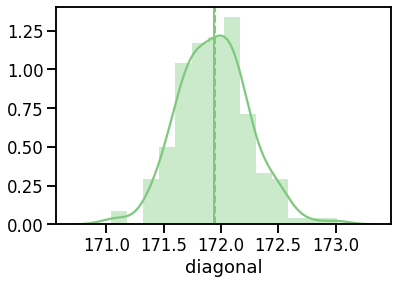

Skewness:  0.19443137121477527
Kurtosis:  0.5346375075188288


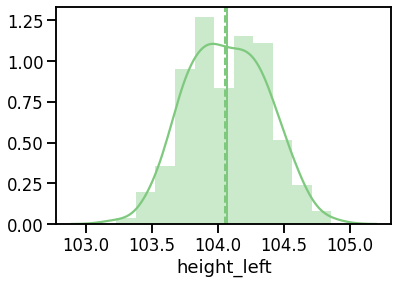

Skewness:  0.02839494808973424
Kurtosis:  -0.4833327619035872


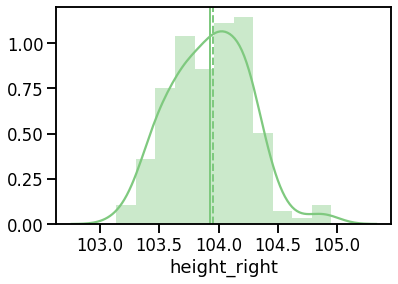

Skewness:  0.16739211723354264
Kurtosis:  -0.03982952213509616


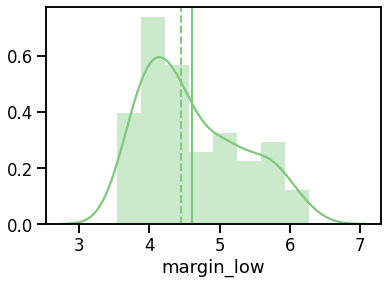

Skewness:  0.5796855414374862
Kurtosis:  -0.75717722821391


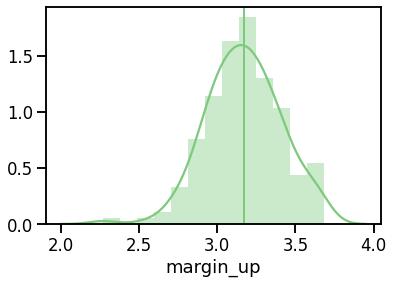

Skewness:  -0.2025055216127945
Kurtosis:  0.49813176957106853


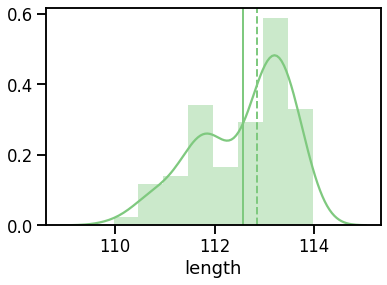

Skewness:  -0.6506712141894133
Kurtosis:  -0.5531969324412676


In [11]:
cols = data[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']]

for i in cols:
  _ = sns.distplot(data[i])
  _ = plt.axvline(x=data[i].mean(), label='Moyenne', linestyle='-', linewidth=2)
  _ = plt.axvline(x=data[i].median(), label='Médiane', linestyle='--', linewidth=2)
  _ = plt.show()
  print('Skewness: ', str(st.stats.skew(data[i])))
  print('Kurtosis: ', str(st.stats.kurtosis(data[i])))

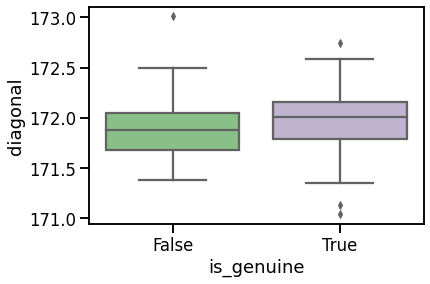

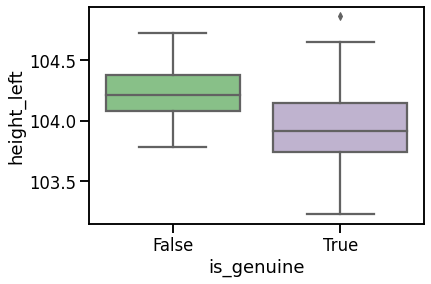

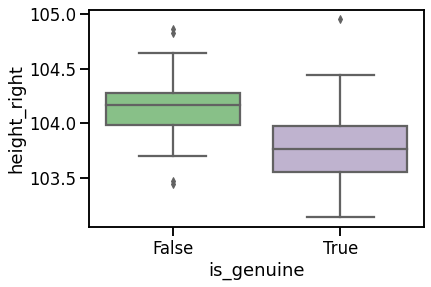

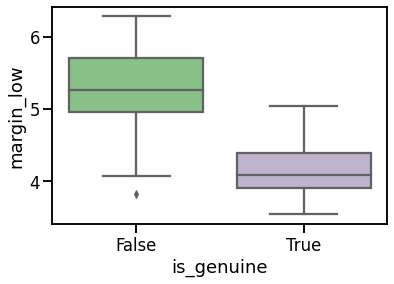

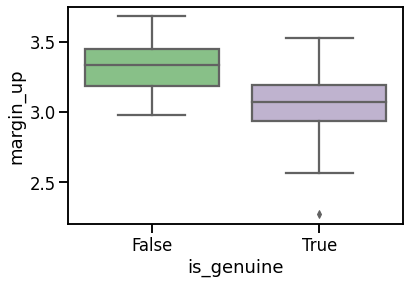

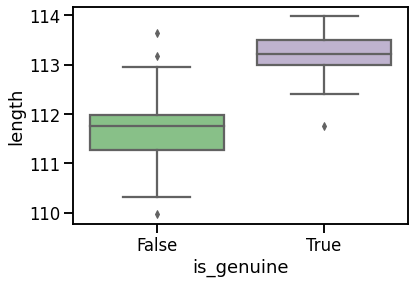

In [12]:
for i in cols: 
  _ = sns.boxplot(y=i, x='is_genuine', data=data)
  _ = plt.show()

In [13]:
for i in cols:
  X = data['is_genuine'] # qualitative
  Y = data[i] # quantitative
  print('eta-squared :', eta_squared(X,Y))

eta-squared : 0.019383108567093802
eta-squared : 0.21319458315018705
eta-squared : 0.30394154672012125
eta-squared : 0.640177214288775
eta-squared : 0.3396567096032002
eta-squared : 0.6818507654957807


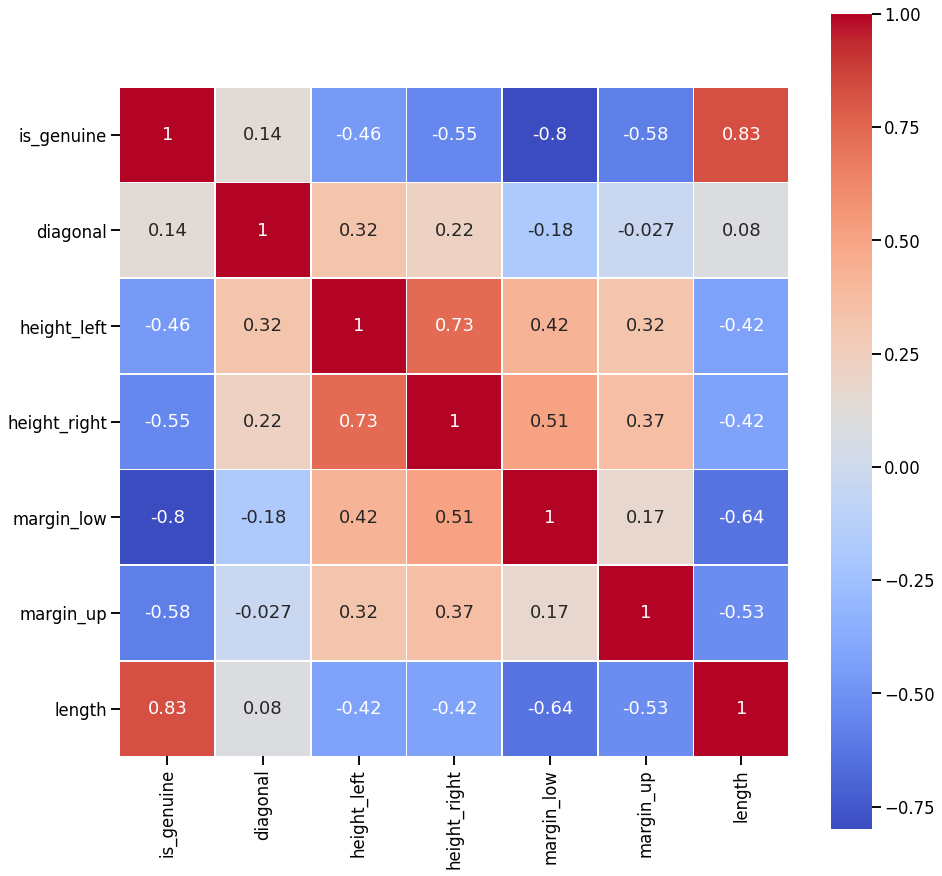

In [14]:
corrMatrix = data.corr()
plt.figure(figsize=(15,15))
_ = sns.heatmap(corrMatrix, square=True, annot=True, linewidths=.5, cmap='coolwarm')
_ = plt.show()

**Mission 1** : Vous réaliserez une analyse en composantes principales de l'échantillon, en suivant toutes ces étapes :

- Analyse de l'éboulis des valeurs propres ;
- Représentation des variables par le cercle des corrélations ;
- Représentation des individus par les plans factoriels ;
- Analyse de la qualité de représentation et la contribution des individus.

Pour chacune de ces étapes, commentez les résultats obtenus. La variable donnant la nature Vrai/Faux du billet sera utilisée comme variable illustrative.

In [15]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

In [16]:
n_comp = 4

data_pca = data[["diagonal","height_left","height_right","margin_low","margin_up","length"]]
X = data_pca.values
names = data.index# ou data.index pour avoir les intitulés
features = data.columns

In [17]:
# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [18]:
# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

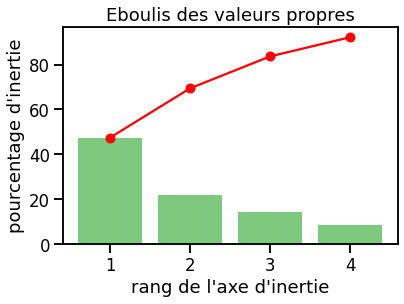

In [19]:
# Eboulis des valeurs propres
display_scree_plot(pca)

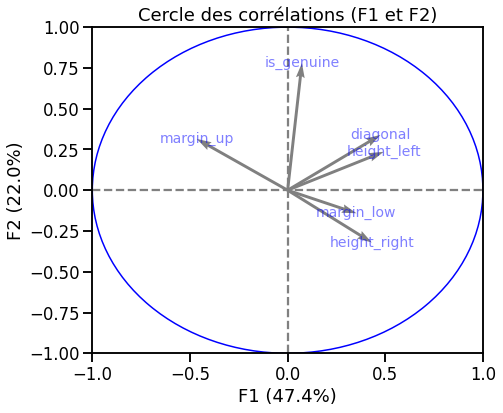

In [20]:
# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

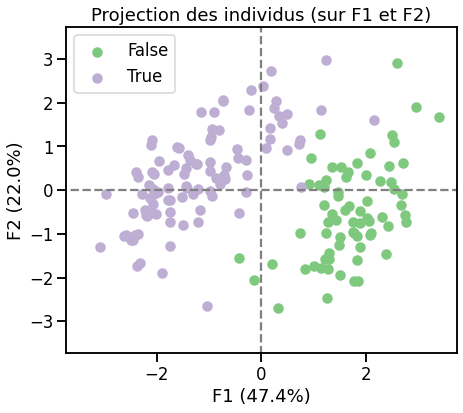

In [21]:
# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var=data['is_genuine'])

**Mission 2** : Appliquez un algorithme de classification, puis analysez le résultat obtenu.
Visualisez la partition obtenue dans le premier plan factoriel de l'ACP, puis analysez-la.

In [22]:
 def plot_dendrogram(Z, names):
    plt.figure(figsize=(10,25))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('distance')
    dendrogram(
        Z,
        labels = names,
        orientation = "left",
    )
    plt.show()

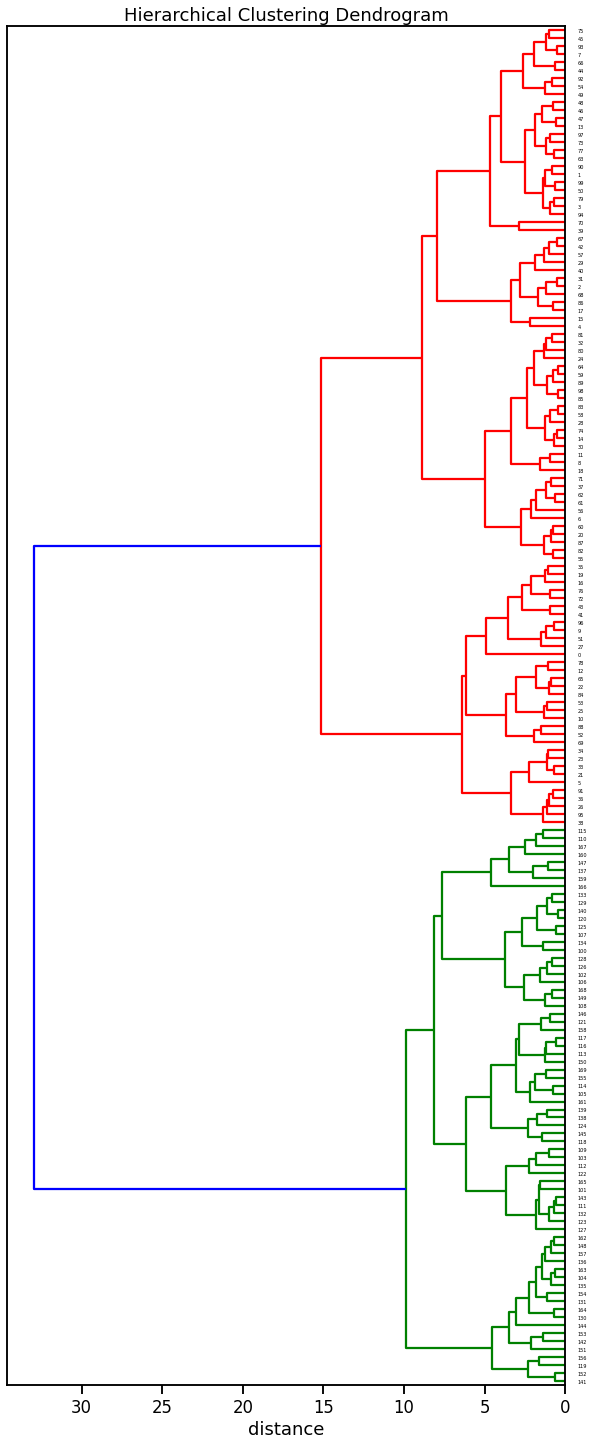

In [23]:
# préparation des données pour le clustering
X = data.values
names = data.index

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Clustering hiérarchique
Z = linkage(X_scaled, 'ward')

# Affichage du dendrogramme
plot_dendrogram(Z, names)

In [24]:
# Coupage du dendrogramme en 2 clusters
clusters = fcluster(Z, 2, criterion='maxclust')

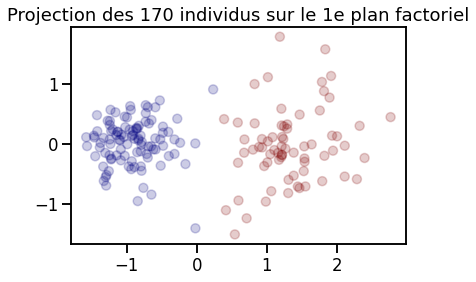

In [25]:
n_clust = 2

X = data.values

# Réduire n'est ici pas nécessaire car les variables sont exprimées dans la même unité
# X_scaled = preprocessing.StandardScaler().fit_transform(X)

# Clustering par K-means
km = KMeans(n_clusters=n_clust)
km.fit(X)

# Récupération des clusters attribués à chaque individu
clusters = km.labels_

# Affichage du clustering par projection des individus sur le premier plan factoriel
pca = decomposition.PCA(n_components=3).fit(X)
X_projected = pca.transform(X)
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=clusters.astype(np.float), cmap = 'jet', alpha=.2)
plt.title("Projection des {} individus sur le 1e plan factoriel".format(X_projected.shape[0]))
plt.show(block=False)

**Mission 3** : Modélisez les données à l'aide d'une régression logistique. Grâce à celle-ci, vous créerez un programme capable d'effectuer une prédiction sur un billet, c'est-à-dire de déterminer s'il s'agit d'un vrai ou d'un faux billet. Pour chaque billet, votre algorithme de classification devra donner la probabilité que le billet soit vrai. Si cette probabilité est supérieure ou égale à 0.5, le billet sera considéré comme vrai. Dans le cas contraire, il sera considéré comme faux.